<a href="https://colab.research.google.com/github/LordVernon/CV_Book/blob/main/3DML_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mesh_to_sdf pyrender trimesh
!pip install torch torchvision
!pip install git+https://github.com/facebookresearch/pytorch3d.git@v0.2.0

     |████████████████████████████████| 1.2MB 6.4MB/s 
     |████████████████████████████████| 634kB 18.0MB/s 
     |████████████████████████████████| 890kB 35.5MB/s 
     |████████████████████████████████| 1.2MB 44.3MB/s 
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-cp36-none-any.whl size=1745212 sha256=d19c7931c3e5f43851a412d4970714f44d0f0b25de3d02bf55eb22d9a70fde47
  Stored in directory: /root/.cache/pip/wheels/6c/00/7f/1dd736f380848720ad79a1a1de5272e0d3f79c15a42968fb58
Successfully built PyOpenGL
  Found existing installation: PyOpenGL 3.1.5
    Uninstalling PyOpenGL-3.1.5:
      Successfully uninstalled PyOpenGL-3.1.5
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision v0.2.0) to /tmp/pip-req-build-4dptb59u
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-4dptb59u
  Running command git checkout -q 686c8666d31d932ed42d3cd7319f249fc75e89a9
     |████████████████████████████████| 276kB 14.0MB/s 
  Create

In [ ]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import torch

# untilitis 
from pytorch3d.utils import ico_sphere

# io utils
from pytorch3d.io import load_obj

# operations with data
from pytorch3d.ops import sample_points_from_meshes

# datastructures
from pytorch3d.structures import Meshes, Textures

# render 
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    DirectionalLights, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader
)

# mesh_to_sdf lib by marian42
from mesh_to_sdf import mesh_to_sdf, sample_sdf_near_surface

# trimesh lib imports
import trimesh
from trimesh.voxel.creation import voxelize

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  torch.cuda.set_device(device)
else:
  device = torch.device('cpu')

# Trimesh sphere .obj model
trimesh_sphere = trimesh.primitives.Sphere(subdivisions= 4)

# Sphere mesh in pytorch3d
#sphere_mesh = ico_sphere(4, device)

#verts_rgb = torch.ones_like(sphere_mesh.verts_list()[0])[None]

# Rainbow sphere in pytorch3d
# verts_rgb = torch.rand_like(sphere_mesh.verts_list()[0])[None]

#sphere_mesh.textures = Textures(verts_rgb=verts_rgb.to(device))

In [ ]:
bunny_trimesh = trimesh.load("Stone.obj")

if isinstance(bunny_trimesh, trimesh.Scene):
    bunny_trimesh = bunny_trimesh.dump(concatenate=True)

bunny_trimesh.vertices -= bunny_trimesh.center_mass
scaling = 2 / bunny_trimesh.scale
bunny_trimesh.apply_scale(scaling=scaling)

verts, faces_idx, _ = load_obj("Stone.obj")
faces = faces_idx.verts_idx

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)

# Rainbow bunny in pytorch3d
# verts_rgb = torch.rand_like(verts)[None]

textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the bunny.
bunny_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)
bunny_trimesh.show()

/usr/local/lib/python3.6/dist-packages/pytorch3d/io/obj_io.py:484: UserWarning: Mtl file does not exist: Stone.mtl
  warnings.warn(f"Mtl file does not exist: {f_mtl}")


In [ ]:
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=1024, 
    blur_radius=0, 
    faces_per_pixel=10, 
)

# We can add a point light in front of the object. 
#lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
ambient_color = torch.FloatTensor([[0.0, 0.0, 0.0]]).to(device)
diffuse_color = torch.FloatTensor([[1.0, 1.0, 1.0]]).to(device)
specular_color = torch.FloatTensor([[0.1, 0.1, 0.1]]).to(device)
direction = torch.FloatTensor([[1, 1, 1]]).to(device)
lights = DirectionalLights(ambient_color=ambient_color,
                           diffuse_color=diffuse_color,
                           specular_color=specular_color,
                           direction=direction,
                           device=device)

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
        )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


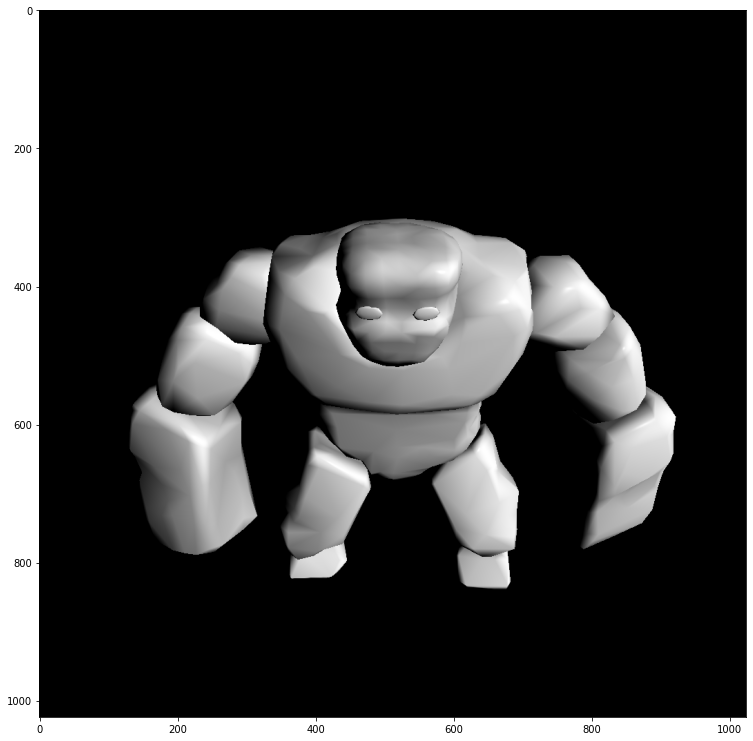

In [ ]:
# Select the viewpoint using spherical angles  
distance = 2.0   # distance from camera to the object`
elevation = 40.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device,at=((-0.02,0.1,0.0),))

# Render the bunny providing the values of R and T. 
image_bunny = phong_renderer(meshes_world=bunny_mesh, R=R, T=T)

image_bunny = image_bunny.cpu().numpy()

plt.figure(figsize=(13, 13))
plt.imshow(image_bunny.squeeze())
plt.grid(False)

In [ ]:
low_idx_bunny = bunny_trimesh.scale / 15
high_idx_bunny = bunny_trimesh.scale / 99
low_idx_sphere = trimesh_sphere.scale / 15
high_idx_sphere = trimesh_sphere.scale / 30
vox_high_bunny = voxelize(bunny_trimesh,pitch=high_idx_bunny)
vox_low_bunny = voxelize(bunny_trimesh, pitch=low_idx_bunny)
vox_high_sphere = voxelize(trimesh_sphere,pitch=high_idx_sphere)
print("Размер воксельной сетки с высоким разрешением:", vox_high_bunny.shape)
#print("Размер воксельной сетки с низким разрешением:", vox_low_sphere.shape)
print("Срез воксельной сетки:\n",np.array(vox_high_bunny.matrix, dtype=np.uint8)[1])

Размер воксельной сетки с высоким разрешением: (76, 61, 23)
Срез воксельной сетки:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
vox_low_bunny.show()


In [ ]:
vox_high_bunny.show()

In [ ]:
print(
    "Эйлерова характеристика пространственного графа модели Stone Xi = V - E + F =",
    bunny_trimesh.euler_number
)


print("Is Stone mesh watertight:", bunny_trimesh.is_watertight)

print("Объем модели Stone.obj:", bunny_trimesh.volume)

Эйлерова характеристика пространственного графа модели Stone Xi = V - E + F = 17
Is Stone mesh watertight: False
Объем модели Stone.obj: 0.2060770046876376


In [ ]:
num_points_to_sample = 50000

bunny_vert, bunny_norm = sample_points_from_meshes(
    bunny_mesh,
    num_points_to_sample ,
    return_normals=True
)

In [ ]:
def plot_pointcloud(points, elev=70, azim=0, title=""):
    # Sample points uniformly from the surface of the mesh.
    fig = plt.figure(figsize=(20, 20))
    ax = Axes3D(fig)
    x, y, z = points
    ax.scatter3D(x, z, -y,marker='.')  
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(elev, azim)
    plt.show()

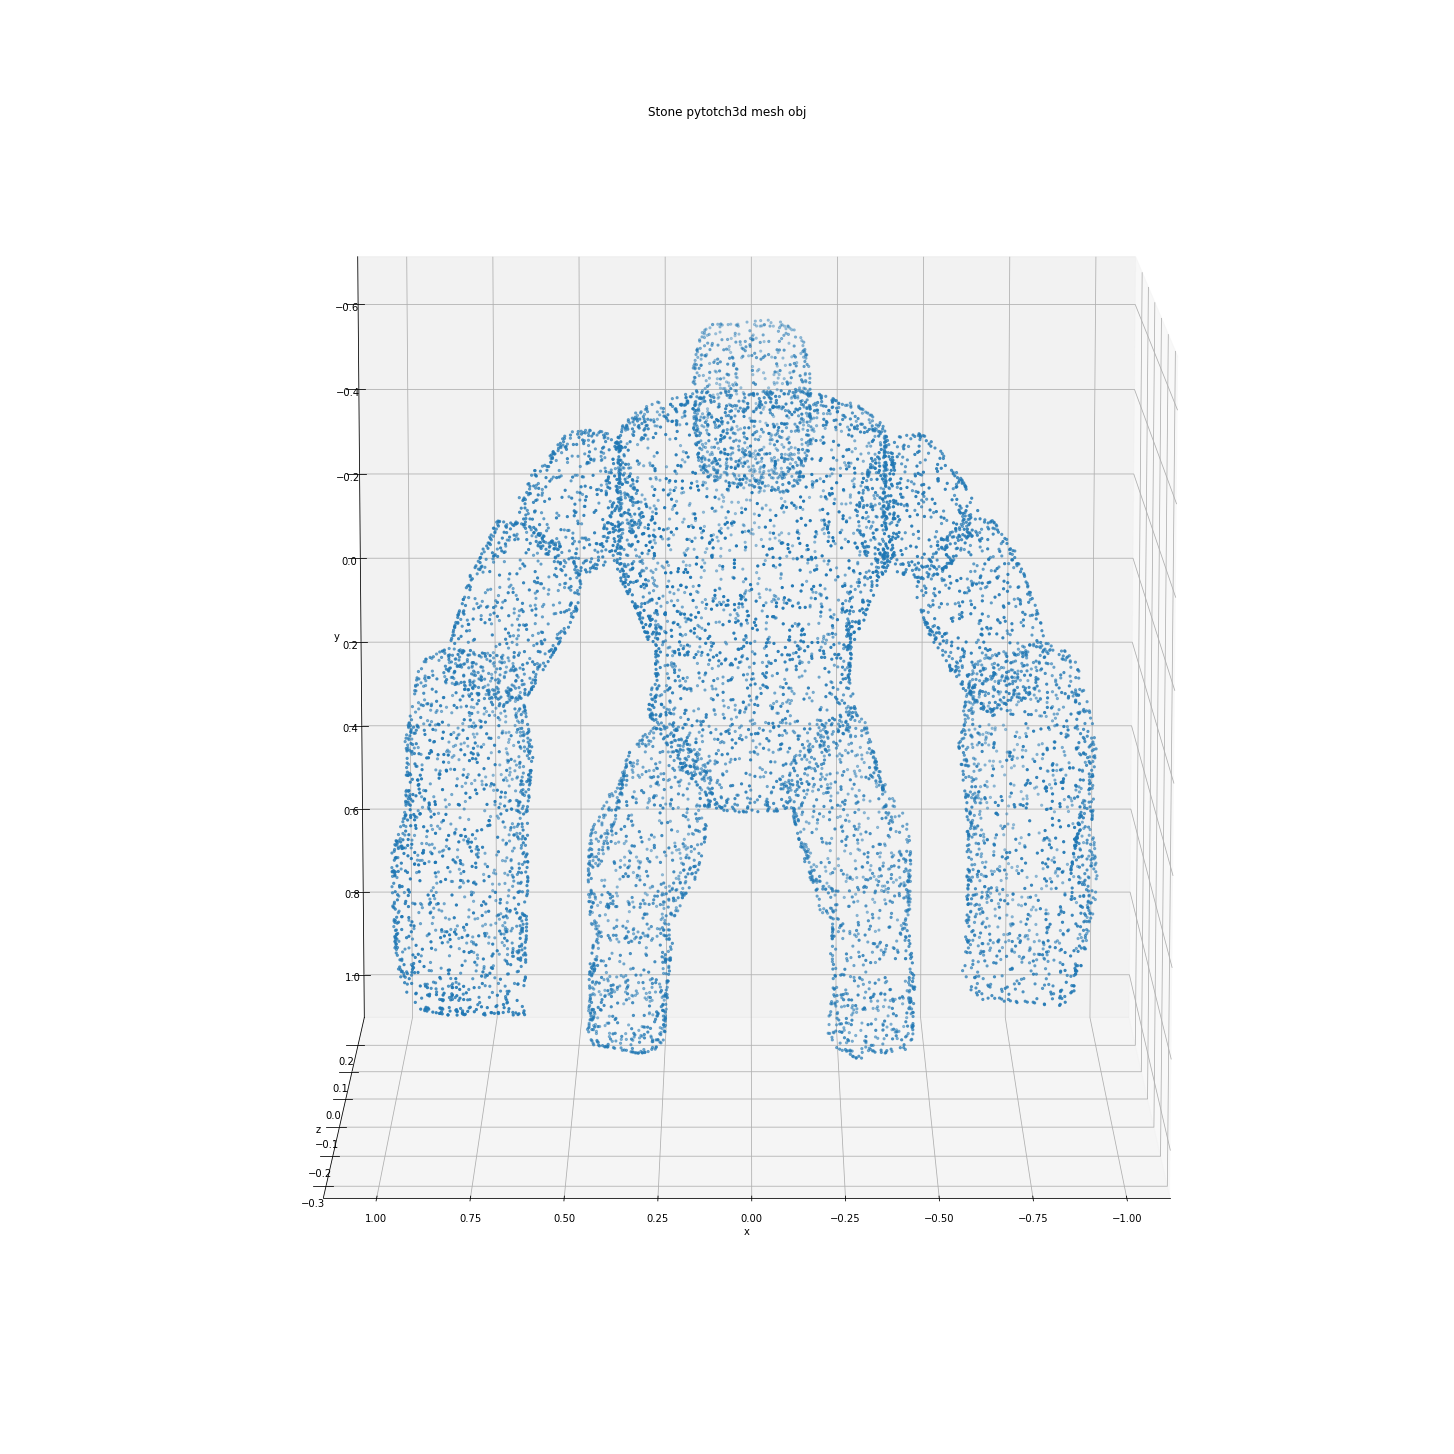

In [ ]:
points = sample_points_from_meshes(bunny_mesh, 10000)
points = points.clone().detach().cpu().squeeze().unbind(1)
plot_pointcloud(points, elev=190, azim=90, title='Stone pytotch3d mesh obj')

In [ ]:
center_mass = bunny_trimesh.center_mass
query_points = np.array([[center_mass],[[3,3,3]]])
for point in query_points:
    print("SDF{0} = {1}".format(point[0],mesh_to_sdf(bunny_trimesh,point)[0]))



SDF[-2.10446027e-17  4.48951524e-17 -1.40297351e-18] = -0.10336004197597504
SDF[3. 3. 3.] = 4.713456153869629


In [ ]:
points, sdf = sample_sdf_near_surface(bunny_trimesh, number_of_points=5000)
fig = plt.figure(figsize=(20, 18))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(elev=70, azim=-90)
ax.scatter(points[:, 0], points[:, 1], zs=-points[:, 2], c=sdf, cmap="hot_r")